In [1]:

import mne
import numpy as np
import joblib
import pickle
TARGET_SAMPLING_RATE=250
window_size= 2500
overlap = 0.5 #50% overlap
filename='lr_cv.joblib'

Using matplotlib as 2D backend.


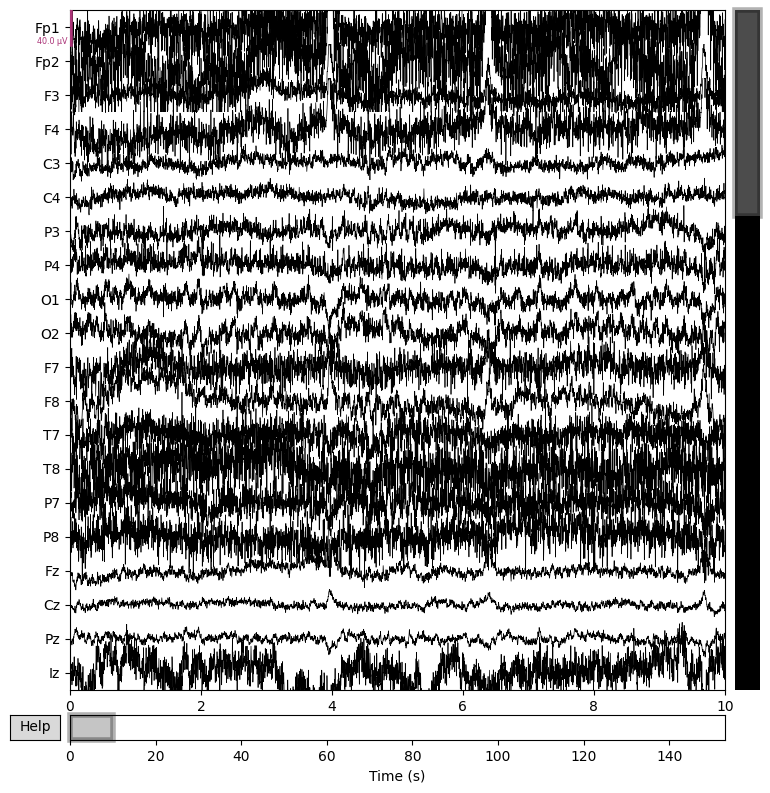

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


e:\Penn State Homework\Homework\CMPSC\CMPSC 445 Proj\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


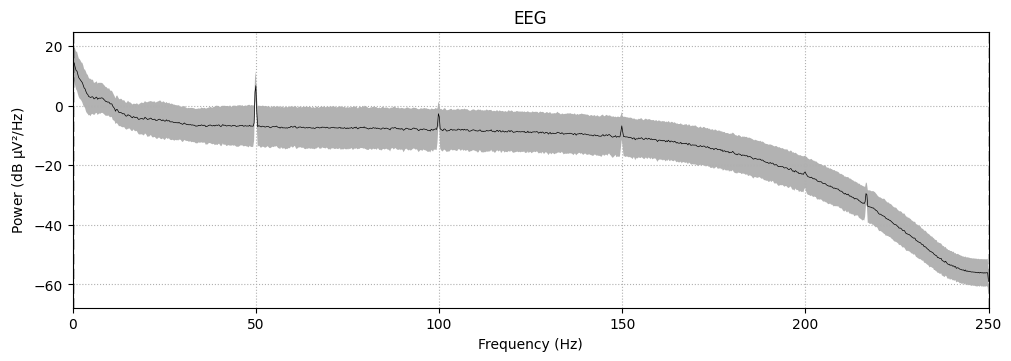

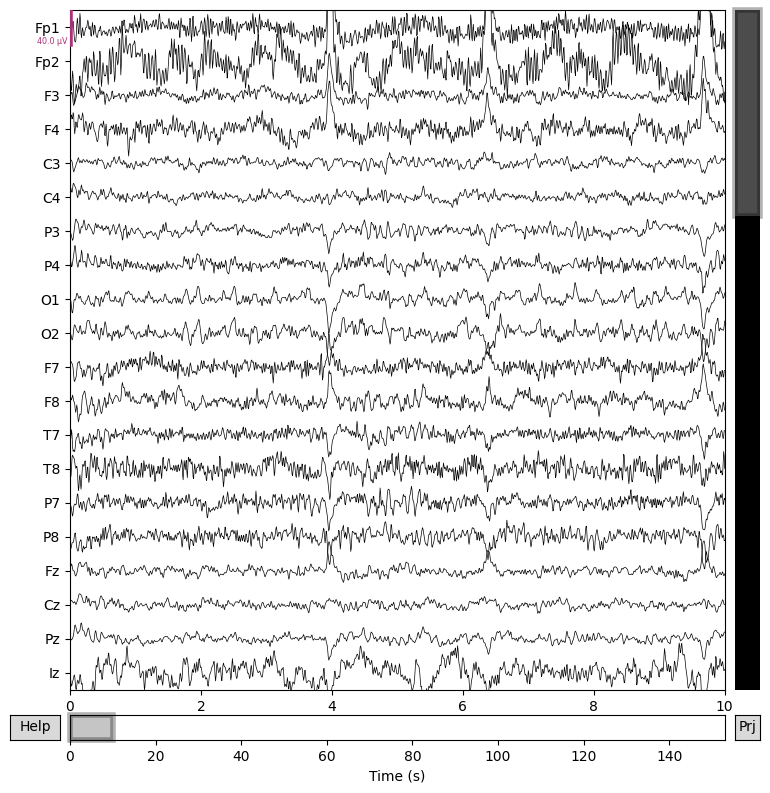

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Prediction:

e:\Penn State Homework\Homework\CMPSC\CMPSC 445 Proj\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


 Non-Parkinson's
Confidence: 62.121862024130394 %


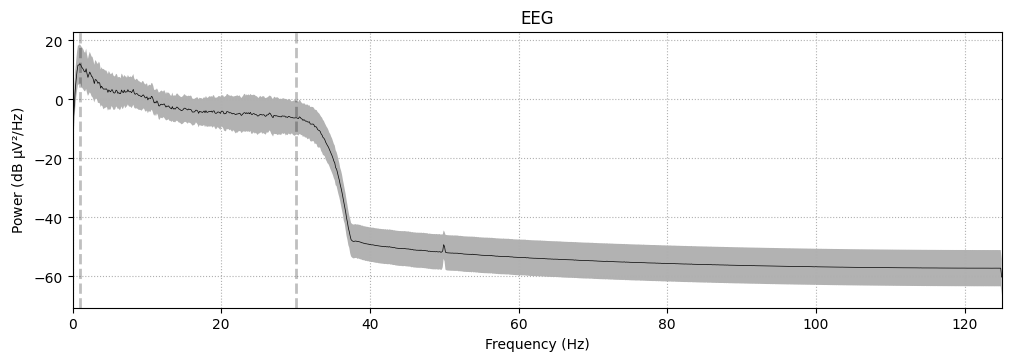

In [2]:
'''
Same as the logic inside the for-loop used for creating the dataset from all the .set files
Cut down to work with a single file and not worry about the file name (PREP)

Modified to create and save plots of EEG data
'''
def process_single_file(file_path, window_size=2500):

    #Read EEG file as MNE object
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    
    #Plot unprocessed EEG channel recordings and the EEG data PSD and save these plots
    UnprocessedRaw=raw.plot()
    UnprocessedRaw.savefig('UnprocessedRaw.png')
    UnprocessedRawPSD=raw.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
    UnprocessedRawPSD.savefig('UnprocessedRawPSD.png')

    
    raw.set_eeg_reference('average', projection=True,verbose=False)
    raw.resample(TARGET_SAMPLING_RATE, npad="auto",verbose=False)
    raw.filter(1., 30., fir_design='firwin', n_jobs='cuda',verbose=False)
    
    ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard',verbose=False)
    ica.fit(raw,verbose=False)
    raw = ica.apply(raw,verbose=False)
    
    #Plot processed EEG channel recordings and the EEG data PSD and save these plots
    ProcessedRaw=raw.plot()
    ProcessedRaw.savefig("ProcessedRaw.png")
    ProcessedRawPSD=raw.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
    ProcessedRawPSD.savefig("ProcessedRawPSD.png")
        
    data = raw.get_data().T
    
    #Make multiple windows
    windows = []
    if data.shape[0] >= window_size:
        stride= int(window_size*(1-overlap))
        for start in range(0, data.shape[0] - window_size + 1, stride):
            window = data[start:start + window_size, :]
            windows.append(window)
        
    return np.stack(windows)

#Predict a result for the input file
def predict_file(file_path, model, scaler, window_size=2500):
    windows = process_single_file(file_path, window_size)
    X = windows.reshape(windows.shape[0], -1)
    X_scaled = scaler.transform(X)
    
    #Predictions for all windows
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    
    #Majority voting
    final_prediction = np.bincount(predictions).argmax()
    final_probability = np.mean(probabilities, axis=0)
    #file_prediction_prob_avg = np.argmax(final_probability)
    return final_prediction, final_probability


lr_model = joblib.load(filename)
# print(lr_model.n_features_in_)
file_path = "fresh data\\05_eyesOpen.set"
scaler=joblib.load('scaler.gz')
prediction, probability = predict_file(file_path, lr_model, scaler, window_size=window_size)
prediction_label="Parkinson's" if prediction == 1 else "Non-Parkinson's"
print("Prediction:",prediction_label)
print("Confidence:",max(probability)*100,"%")
# print("Prob Avg:",prob_avg)